In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
import sklearn 
import scipy
import random
import warnings

%matplotlib inline

In [3]:
from scipy.io import loadmat

mnist_org = loadmat('mnist-original.mat')
X, y = mnist_org['data'].transpose(), mnist_org['label'].transpose()

In [4]:
X.shape

(70000, 784)

In [5]:
y.shape

(70000, 1)

<em> There are 70,000 images, and each image has 784 features. This is because each image
is 28×28 pixels, and each feature simply represents one pixel’s intensity, from 0
(white) to 255 (black). 

### Looking at one digit 

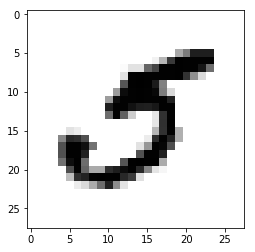

[5.]


In [78]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.show()
print(y[32000])

<br><em>The MNIST dataset is already split into a training set (the first 60,000
images) and a test set (the last 10,000 images):

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

<br><em> Need to shuffle the training set now. This will guarantee that all cross-validation folds will
be similar. Moreover, some learning
algorithms are sensitive to the order of the training instances, and they perform
poorly if they get many similar instances in a row.

In [8]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### Training a Binary Classifier

<em> Simplify the problem for now and only try to identify one digit—for example,
the number 5. This “5-detector” will be an example of a binary classifier, capable of
distinguishing between just two classes, 5 and not-5

In [9]:
y_train_5 = (y_train == 5)
y_test_5  = (y_test == 5)

<br><em> SGD classifier
has the advantage of being capable of handling very large datasets efficiently.
This is in part because SGD deals with training instances independently, one at a time
(which also makes SGD well suited for online learning)

In [10]:
from sklearn.linear_model import SGDClassifier
from warnings import filterwarnings

filterwarnings('ignore')
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
# sgd_clf.predict([X[36000]])

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [11]:
from sklearn.model_selection import cross_val_score

cv = cross_val_score(estimator=sgd_clf, X=X_train, y= np.ravel(y_train_5), cv=5, scoring='accuracy')

### Custom cross validation function

In [12]:
def cross_val_custom(estimator, X, y, scoring, cv=5):
    
    split_x = np.array_split(X, cv)
    split_y = np.array_split(y, cv)
    
    scores = []
    
    for i in range(cv):
        
        train_splits = list(range(cv))
        train_splits.remove(i)
        
        training_x_folds = split_x[train_splits[0]]
        training_y_folds = split_y[train_splits[0]]
        
        for j in train_splits[1:]:
            training_x_folds = np.concatenate((training_x_folds, split_x[j]), axis = 0)
            training_y_folds = np.concatenate((training_y_folds, split_y[j]), axis = 0)
    
        validation_fold = split_x[i]
        estimator.fit(training_x_folds, training_y_folds)
        predictions = estimator.predict(validation_fold)
        scores.append(scoring(split_y[i], predictions))
        
    return scores

<br><em>Due to having low number of positives, this classification yields higher accuracy. 
This can be seen from the below dumb classifier that classify everything into the "not5" category

In [13]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [14]:
never_5 = Never5Classifier()

cv = cross_val_score(estimator=never_5, X=X_train, y= np.ravel(y_train_5), cv=5, scoring='accuracy')
cv

array([0.90866667, 0.91025   , 0.9095    , 0.90633333, 0.9135    ])

In [15]:
y_train_5.sum() / len(y_train_5) * 100

9.035

<em> Since more than 10% of the images are not 5, accuracy of predicting a image not being equal to 5 is higher than 90%

## Alternate classification metrics

In [16]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

<em>Just like the cross_val_score() function, cross_val_predict() performs K-fold
cross-validation, but instead of returning the evaluation scores, it returns the predictions
made on each test fold.

In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

confusion_matrix(y_train_5, y_train_pred)

array([[53507,  1072],
       [ 1362,  4059]], dtype=int64)

In [18]:
accuracy_score(y_train_5, y_train_pred)

0.9594333333333334

In [19]:
precision_score(y_train_5, y_train_pred)

0.7910738647437147

In [20]:
recall_score(y_train_5, y_train_pred)

0.7487548422800221

In [21]:
f1_score(y_train_5, y_train_pred)

0.7693328278999241

#### Precision-recall trade-off

<em>Scikit-Learn does not let you set the threshold directly, but it does give you access to
the decision scores that it uses to make predictions. Instead of calling the classifier’s
predict() method, you can call its decision_function() method, which returns a
score for each instance, and then make predictions based on those scores using any
threshold you want:

In [22]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([7097.19989347])

In [23]:
threshold = 0
y_scores > threshold

array([ True])

<em>The SGDClassifier uses a threshold equal to 0, so the previous code returns the same
result as the predict() method (i.e., True).

In [24]:
threshold = 50000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [25]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

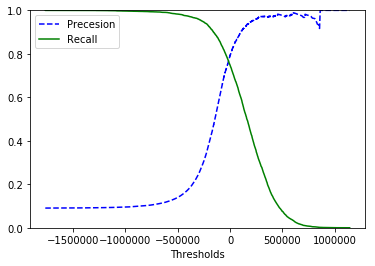

In [26]:
# Now with these scores you can compute precision and recall for all possible thresholds
# using the precision_recall_curve() function:

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label='Precesion')
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel('Thresholds')
    plt.legend(loc='upper-left')
    plt.ylim([0,1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

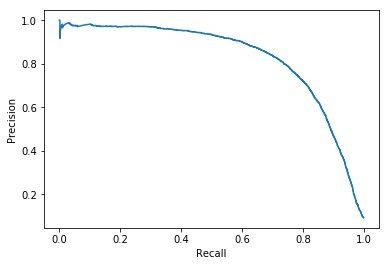

In [27]:
## Plotting Precision against recall 
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

<em>You can see that precision really starts to fall sharply around 80% recall. You will
probably want to select a precision/recall tradeoff just before that drop—for example,
at around 60% recall.

In [28]:
# Aiming for a 90% recall 

y_train_pred_90 = (y_scores > 50000)
precision_score(y_train_5, y_train_pred_90)

0.8531322505800464

In [29]:
recall_score(y_train_5, y_train_pred_90)

0.6782881387197934

## ROC (Receiver Operating Curve)

<em>ROC curve plots the true positive rate(recall) against the false positive rate (negative classified as positive)

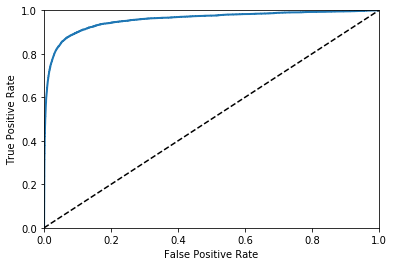

In [30]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)

<em>Once again there is a tradeoff: the higher the recall (TPR), the more false positives
(FPR) the classifier produces.

<br><em>One way to compare classifiers is to measure the area under the curve (AUC). A perfect
classifier will have a ROC AUC equal to 1, whereas a purely random classifier will
have a ROC AUC equal to 0.5.

In [31]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9568397744923859

In [32]:
## Training a random forest classifier 
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

# Random forests doesn't have a decision_function() method
y_predict_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

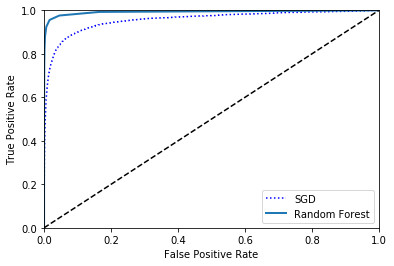

In [33]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="bottom right")
plt.show()

In [96]:
print("AUC Curve value - ", roc_auc_score(y_train_5, y_scores_forest))
print("Precision - ", precision_score(y_train_5, y_predict_forest))
print("Recall - ", recall_score(y_train_5, y_predict_forest))

AUC Curve value -  0.9919009813269088
Precision -  0.986969964664311
Recall -  0.8243866445305295


# Multiclass classification

<em>
- The one-versus-all (OvA) strategy creates binary classifiers for all the classes. Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose
classifier outputs the highest score.
    
- Another strategy is to train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. This is called the one-versus-one (OvO) strategy.

- Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass
classification task, and it automatically runs OvA (except for SVM classifiers for
which it uses OvO).

In [39]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([6.])

In [40]:
# Returns scores for each class 
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[ -99961.75024145, -667979.30497501, -603569.79516161,
         -23882.41260691, -733006.45894728,  -64121.87392405,
          50201.2395853 , -572208.02873255, -285933.51953289,
        -906239.84942252]])

In [41]:
np.argmax(some_digit_scores)

6

In [65]:
# multiclass classifier using the OvO strategy, based on a SGDClassifier

from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(estimator=sgd_clf)
ovo_clf.fit(X_train, y_train)

OneVsOneClassifier(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
          n_jobs=None)

In [66]:
ovo_clf.predict([some_digit])

array([5.])

In [68]:
ovo_clf.decision_function([some_digit])

array([[ 6.24184258, -0.32455894,  1.91090272,  6.03076433,  1.60571136,
         9.5       ,  6.07503418,  1.6214325 ,  8.34049338,  3.99837789]])

<br><em>Scikit-Learn does not have to run OvA or OvO because Random Forest
classifiers can directly classify instances into multiple classes.

In [73]:
forest_clf.fit(X_train, y_train)

In [79]:
forest_clf.predict([some_digit])

array([5.])

In [80]:
forest_clf.predict_proba([some_digit])

array([[0.1, 0. , 0. , 0. , 0. , 0.9, 0. , 0. , 0. , 0. ]])

In [81]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.83933213, 0.85484274, 0.86487973])

In [88]:
## Scale the inputs to improve the accuracy 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.91116777, 0.91039552, 0.90873631])

## Error Analysis 

In [112]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [92]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5725,    3,   22,    9,   10,   55,   48,    9,   39,    3],
       [   1, 6472,   45,   31,    6,   47,    7,   11,  110,   12],
       [  50,   37, 5331,  107,   83,   22,   98,   57,  160,   13],
       [  46,   37,  145, 5343,    6,  238,   31,   53,  140,   92],
       [  19,   26,   41,   11, 5346,   11,   59,   32,   76,  221],
       [  64,   40,   38,  176,   78, 4625,  109,   27,  169,   95],
       [  28,   22,   51,    1,   39,   90, 5636,    4,   47,    0],
       [  24,   18,   63,   33,   57,    8,    6, 5805,   14,  237],
       [  49,  148,   70,  162,   18,  171,   54,   24, 5007,  148],
       [  35,   33,   28,   82,  148,   37,    2,  185,   83, 5316]],
      dtype=int64)

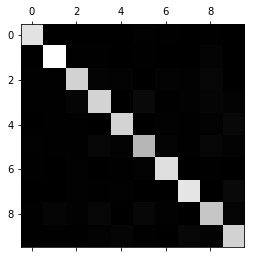

In [99]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

In [108]:
row_sum = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sum

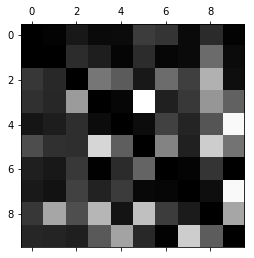

In [110]:
np.fill_diagonal(norm_conf_mx, 0) # fill the diagonal with zeros to keep only the errors
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

<em> It can be seen from the above plot that, mainly 8 and 9 values are misclassified. 1 value is fairly easily classified. <br> There's a big problem with ambguitiy between 3 and 5

In [157]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

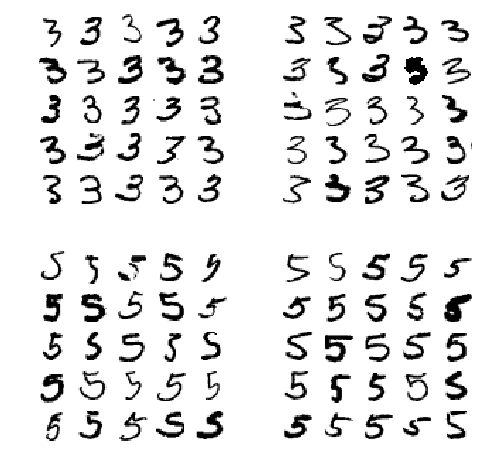

In [158]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train.flatten() == cl_a ) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train.flatten() == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train.flatten() == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train.flatten() == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## Multilabel Classification